# Подготовка исходных данных

Описывается порядок работы и взаимодействия следующих модулей:

- **Ф26**: Модуль ценностно-ориентированного моделирования программ развития населенного пункта.
- **Ф35**: Модуль прогнозирования эффектов трансформации территории в масштабах населенного пункта и региона.
- **Ф36**: Модуль генерации ценностно-ориентированных требований к трансформации территорий.

Важно принять во внимание, что основная часть работы лежит на модуле **Ф35**. Остальные модули используют промежуточные результаты работы данного модуля.

In [1]:
USER_SCENARIO_ID = 615 #610

In [2]:
import pandas as pd
import geopandas as gpd

import prostor.fetchers.scenarios as scenarios
import prostor.fetchers.projects as projects
import prostor.fetchers.territories as territories

from blocksnet.config import log_config

log_config.set_logger_level('ERROR')

## 1. Получение слоя городских кварталов

Получение слоя городских кварталов необходимо выполнять отдельно для территории **контекста** и отдельно для территории самого сценарного **проекта**. При этом результатом будет являться объединенный слой тех и других геометрий.

Для самой территории необходимо учитывать геометрии дорог как до, так и после преобразования для более детального анализа.

Легенда:

- `POF` -- physical object function
- `POT` -- physical object type

In [41]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

BUILDING_POF_ID = 1
WATER_POF_ID = 4
ROADS_POF_ID = 26

import shapely
import numpy as np

def close_gaps(gdf, tolerance): # stolen from momepy
    geom = gdf.geometry.array
    coords = shapely.get_coordinates(geom)
    indices = shapely.get_num_coordinates(geom)

    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = shapely.points(np.unique(coords[edges], axis=0))

    buffered = shapely.buffer(points, tolerance / 2)

    dissolved = shapely.union_all(buffered)

    exploded = [
        shapely.get_geometry(dissolved, i)
        for i in range(shapely.get_num_geometries(dissolved))
    ]

    centroids = shapely.centroid(exploded)

    snapped = shapely.snap(geom, shapely.union_all(centroids), tolerance)

    return gpd.GeoSeries(snapped, crs=gdf.crs)

In [34]:
def _get_scenario_roads(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_scenario_water(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_project_boundaries(project_id : int):
    return gpd.GeoDataFrame(geometry=[projects.get_project_geometry(project_id)], crs=4326)

def _get_context_boundaries(project_id : int) -> gpd.GeoDataFrame:
    project = projects.get_project(project_id)
    context_ids = project['properties']['context']
    geometries = [territories.get_territory_geometry(territory_id) for territory_id in context_ids]
    return gpd.GeoDataFrame(geometry=geometries, crs=4326)

def _get_scenario_info(scenario_id : int) -> tuple[int, int]:
    scenario = scenarios.get_scenario(scenario_id)
    project_id = scenario['project']['project_id']
    project = projects.get_project(project_id)
    base_scenario_id = project['base_scenario']['id']
    return project_id, base_scenario_id

def _get_scenario_blocks(user_scenario_id : int, base_scenario_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    crs = boundaries.estimate_utm_crs()
    boundaries = boundaries.to_crs(crs)
    boundaries.geometry = boundaries.buffer(-1)
    
    water = _get_scenario_water(user_scenario_id).to_crs(crs)

    user_roads = _get_scenario_roads(user_scenario_id)
    base_roads = _get_scenario_roads(base_scenario_id)
    roads = pd.concat([user_roads, base_roads]).reset_index(drop=True).to_crs(crs)
    roads.geometry = close_gaps(roads, 1)
    
    lines, polygons = preprocess_urban_objects(roads, None, water)
    blocks = cut_urban_blocks(boundaries, lines, polygons)
    return blocks.to_crs(4326)

In [35]:
def _get_context_roads(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)


def _get_context_water(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_context_blocks(project_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    crs = boundaries.estimate_utm_crs()
    boundaries = boundaries.to_crs(crs)
    boundaries.geometry = boundaries.buffer(-1)

    water = _get_context_water(project_id).to_crs(crs)
    roads = _get_context_roads(project_id).to_crs(crs)
    roads.geometry = close_gaps(roads, 1)

    lines, polygons = preprocess_urban_objects(roads, None, water)
    blocks = cut_urban_blocks(boundaries, lines, polygons)
    return blocks.to_crs(4326)

In [36]:
def get_scenario_blocks(user_scenario_id : int):
    project_id, base_scenario_id = _get_scenario_info(user_scenario_id)
    project_boundaries = _get_project_boundaries(project_id)
    context_boundaries = _get_context_boundaries(project_id)

    scenario_blocks = _get_scenario_blocks(user_scenario_id, base_scenario_id, project_boundaries)
    context_blocks = _get_context_blocks(project_id, context_boundaries.overlay(project_boundaries, how='difference'))
    blocks = pd.concat([scenario_blocks, context_blocks]).reset_index(drop=True)
    crs = blocks.estimate_utm_crs()
    return blocks.to_crs(crs)

blocks = get_scenario_blocks(USER_SCENARIO_ID)

<Axes: >

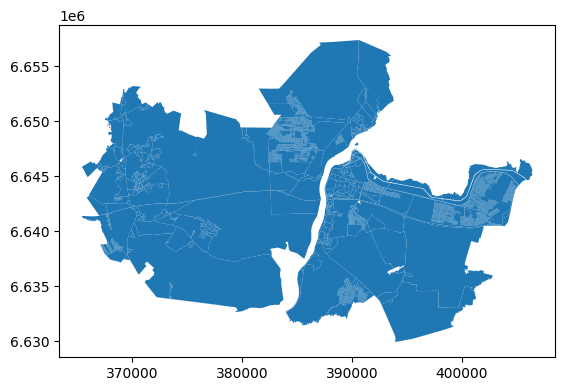

In [39]:
blocks.plot()

In [44]:
LIVING_BUILDING_POT_ID = 4

In [46]:
buildings = projects.get_physical_objects(project_id=120, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)

In [58]:
from prostor.adapters import adapt_buildings

adapt_buildings(buildings).population.sum()

np.float64(0.0)